In [1]:
import os

import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(1966)

from mpl_toolkits.mplot3d.art3d import LineCollection
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors

import rpy2
import anndata2ri

import scanpy
import anndata

import gseapy

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
%matplotlib inline

In [3]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Functions

In [4]:
def plot_G(tsne, G,ax,
           alpha_G=0.7, color_G='r',s=10,t='k',cmap='viridis',colorbar=False):
    
    # generate collection of all edges (assumes symmetric)
    segments = [tsne[[i, j],:] for (i, j) in G.todok().keys() if i < j]
    ax.add_collection(LineCollection(segments, colors=color_G, alpha=alpha_G))

    if colorbar:
        plt.colorbar()
    plt.axis("off")
    ax.scatter(tsne[:,0],tsne[:,1],s=s,c=t,cmap=cmap,edgecolor='k',zorder=10,vmin=-5,vmax=5)
    return ax

#using script from Joe Chan
def convert_genes(genes_to_map,direction='h2m'):
    pd.DataFrame(genes_to_map,columns=['Genes']).to_csv("scripts/script_intermediates/genes_tmp.csv")
    command = "Rscript scripts/ConvertHuman2MouseGenes_Joe_CNBEdit.R {}".format(direction)
    os.system(command)
    output = pd.read_csv("scripts/script_intermediates/converted_tmp.csv",index_col=0)
    os.system("rm scripts/script_intermediates/converted_tmp.csv")
    return output['x'].values

def plot_G2(tsne, G,ax,
           alpha_G=0.7, color_G='r',s=10,t='k',cmap='viridis',colorbar=False):
    
    # generate collection of all edges (assumes symmetric)
    segments = [tsne[[i, j],:] for (i, j) in G.todok().keys() if i < j]
    ax.add_collection(LineCollection(segments, colors=color_G, alpha=alpha_G))

    if colorbar:
        plt.colorbar()
    plt.axis("off")
    ax.scatter(tsne[:,0],tsne[:,1],s=s,c=t,cmap=cmap,edgecolor='k',zorder=10)
    return ax

# Hard-coded Metadata

In [5]:
stage_dict = {'DACD346_Kate_plus': 'T4/IL33KD',
 'DACD350_Kate_plus': 'T4',
 'DACD351_Kate_plus': 'T3',
 'DACD347_KATE_PLUS': 'T5/IL33KD',
 'DACD345_KATE_PLUS_GFP': 'T5/IL33KD',
 'DACD349_KATE_PLUS': 'T5',
 'DACE621-mKate2_pos': 'T4',
 'DACE604-mKate2_pos': 'T4/IL33KD',
 'DACE605-mKate2_pos': 'T4/IL33KD',
 'E607-EPI': 'T5/IL33KD',
 'E610-EPI': 'T5',
 'E614-EPI': 'T5/IL33KD'}

In [6]:
cohort_dict = {'DACD346_Kate_plus': 'C1',
 'DACD350_Kate_plus': 'C1',
 'DACD351_Kate_plus': 'C1',
 'DACD347_KATE_PLUS': 'C1',
 'DACD345_KATE_PLUS_GFP': 'C1',
 'DACD349_KATE_PLUS': 'C1',
 'DACE621-mKate2_pos': "C2",
 'DACE604-mKate2_pos': 'C2',
 'DACE605-mKate2_pos': 'C2',
 'E607-EPI': 'C2',
 'E610-EPI': 'C2',
 'E614-EPI': 'C2'}

In [7]:
color_dict= {
"T3":"#EED04D",
"T4":"#1D89E3",
"T5":"#F8BADE",
"T4/IL33KD":"#004b8a",
"T5/IL33KD":"#804e6b"}

In [8]:
#cell type mapping from phenograph clusters to import
acinar = [7,13]
progenitor = [5,4,0,1,11]
mucinous = [3,2,6,10]
tuft = [14]
NE = [8,9,15,16,12]

celltype_dict = dict(acinar=acinar,progenitor=progenitor,tuft=tuft,mucinous=mucinous,NE=NE)

# Set up R Environment

In [9]:
anndata2ri.activate()

In [10]:
%load_ext rpy2.ipython

In [11]:
%%R
library(miloR)
library(igraph)
library(ggplot2)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:miloR’:

    graph


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Need help? Try Stackoverflow: https://stackoverflow.com/tags/ggplot2



# Preparation to Run Milo

## Load Data in Python 

In [12]:
sc = load_sc(working_dir+"saved_analyses/T4_All_NoMes.pickle")

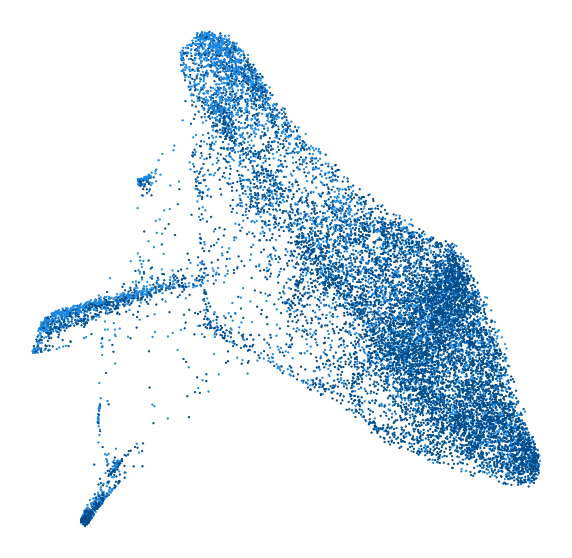

In [13]:
fig,ax=plt.subplots(figsize=(10,10))
colors = [color_dict[stage_dict[sample]] for sample in sc.sample_ids]
ax.scatter(sc.layout_log.values[:,0],sc.layout_log.values[:,1],c=colors,s=2)
ax.set_axis_off()

## Set Up adata Object & Pass to R

In [14]:
cell_barcodes = ["{}_{}".format(sc.cell_ids[i],sc.sample_ids[i]) for i in range(sc.data.shape[0])]
condition = [stage_dict[i] for i in sc.sample_ids]
cohort = [cohort_dict[i] for i in sc.sample_ids]

obs = pd.DataFrame(dict(batch=sc.sample_ids,total_molecules=sc.lib_size.astype(np.int32),
                       condition=condition,cohort=cohort),
                   index=cell_barcodes)

var = pd.DataFrame(index=sc.genes_all)

obsm = {"X_pca":sc.pc_log,
       "X_tsne":sc.layout_log.values,"X_umap":sc.layout_log.values}

num_PCs = sc.npca_log

In [15]:
adata = anndata.AnnData(X=np.log2(sc.data_all.toarray()+.1),
                        obs=obs, 
                        var=var, 
                        uns=None, 
                        obsm=obsm, 
                        varm=None, layers=None, raw=None, dtype='float32', 
                        shape=None, filename=None, filemode=None, asview=False, 
                        obsp=None, varp=None, oidx=None, vidx=None)

In [16]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 15845 13115 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(13115): 120703409153763_DACD346_Kate_plus
  120703409669852_DACD346_Kate_plus ...
  241114608159148_DACE605-mKate2_pos 241114608782195_DACE605-mKate2_pos
colData names(4): batch total_molecules condition cohort
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):


In [17]:
%%R 
milo <- Milo(adata)
milo

class: Milo 
dim: 15845 13115 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(13115): 120703409153763_DACD346_Kate_plus
  120703409669852_DACD346_Kate_plus ...
  241114608159148_DACE605-mKate2_pos 241114608782195_DACE605-mKate2_pos
colData names(4): batch total_molecules condition cohort
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [18]:
%%R -i num_PCs
num_PCs

[1] 53


In [19]:
%%R 
milo <- buildGraph(milo, k=20, d=num_PCs,
  transposed = TRUE,
  get.distance = FALSE,
  reduced.dim = "PCA"
)

R[write to console]: Constructing kNN graph with k:20



In [20]:
%%R
milo

class: Milo 
dim: 15845 13115 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(13115): 120703409153763_DACD346_Kate_plus
  120703409669852_DACD346_Kate_plus ...
  241114608159148_DACE605-mKate2_pos 241114608782195_DACE605-mKate2_pos
colData names(4): batch total_molecules condition cohort
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


# Run Milo

## Prepare Design Matrix for Milo

In [21]:
#define dataframe to input in milo (at least cells x independent variable)
design_df = obs[["batch", "condition",'cohort']]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['batch']
design_df

/Users/burdziac/Documents/bin/miniconda2/envs/MyEnv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,batch,condition,cohort
batch,,,
DACD346_Kate_plus,DACD346_Kate_plus,T4/IL33KD,C1
DACD350_Kate_plus,DACD350_Kate_plus,T4,C1
DACE621-mKate2_pos,DACE621-mKate2_pos,T4,C2
DACE604-mKate2_pos,DACE604-mKate2_pos,T4/IL33KD,C2
DACE605-mKate2_pos,DACE605-mKate2_pos,T4/IL33KD,C2


## Run Milo in R

In [22]:
%%R -i design_df -o DA_results
## Define neighbourhoods
milo <- makeNhoods(milo, prop = 0.1, k = 20, d=num_PCs, refined = TRUE)

## Count cells in neighbourhoods
milo <- countCells(milo, meta.data = data.frame(colData(milo)), sample="batch")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
milo <- calcNhoodDistance(milo, d=num_PCs)

## Test for differential abundance set ~ <confounding_variable>  + <independent variable>

#correcting for confounding variable (key of that variable in original adata.obs)
#DA_results <- testNhoods(milo, design = ~ confounding_variable + independent_variable , design.df = design_df)

#without correcting for confounding variable
DA_results <- testNhoods(milo, design = ~ cohort + condition , design.df = design_df)

R[write to console]: Checking valid object

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



In [23]:
%%R
milo

class: Milo 
dim: 15845 13115 
metadata(0):
assays(1): X
rownames(15845): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(13115): 120703409153763_DACD346_Kate_plus
  120703409669852_DACD346_Kate_plus ...
  241114608159148_DACE605-mKate2_pos 241114608782195_DACE605-mKate2_pos
colData names(4): batch total_molecules condition cohort
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 13115 1048
nhoodCounts dimensions(2): 1048 5
nhoodDistances dimension(1): 1048
graph names(1): graph
nhoodIndex names(1): 1048
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [24]:
DA_results.sort_values('FDR')

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
731,-1.264188,10.438708,2.400529e+00,0.121445,0.658625,731.0,0.634748
746,2.233220,9.804357,3.026568e+00,0.082058,0.658625,746.0,0.634748
177,1.528872,10.687404,2.280124e+00,0.131192,0.658625,177.0,0.634748
747,2.346736,10.224941,5.635714e+00,0.017688,0.658625,747.0,0.634748
496,-1.796246,10.343993,3.223677e+00,0.072724,0.658625,496.0,0.634748
...,...,...,...,...,...,...,...
118,-0.006667,10.221904,7.956624e-06,0.997750,0.999022,118.0,0.998977
288,-0.004750,9.899735,5.858649e-06,0.998069,0.999022,288.0,0.998977
284,-0.005777,10.981519,1.310553e-05,0.997112,0.999022,284.0,0.998977
879,0.004459,10.510071,1.545767e-05,0.996863,0.999022,879.0,0.998977


## Visualize Milo Results

### In R

In [25]:
%%R -w 1000 -h 800
milo <- buildNhoodGraph(milo)
#g <- plotNhoodGraphDA(milo, DA_results, res_column='logFC', layout='UMAP',alpha = 1.0,)
#g

### In Python

In [26]:
%%R -o nhood_graph -o nhood_graph_indices -o nh_size
## Save the adjacency matrix of the nhood graph
nhood_graph = as_adjacency_matrix(nhoodGraph(milo), attr="weight")

##save the indices of the adjacency matrix
nhood_graph_indices = names(nhoodDistances(milo))

## get sizes of neighborhoods
nh_size=colSums(nhoods(milo))

In [27]:
%%R -o nh_tsne_df
## Save the positions in tsne of nhood indices
nh_tsne_df = reducedDim(milo, "TSNE")[unlist(nhoodIndex(milo)),]

<AxesSubplot:>

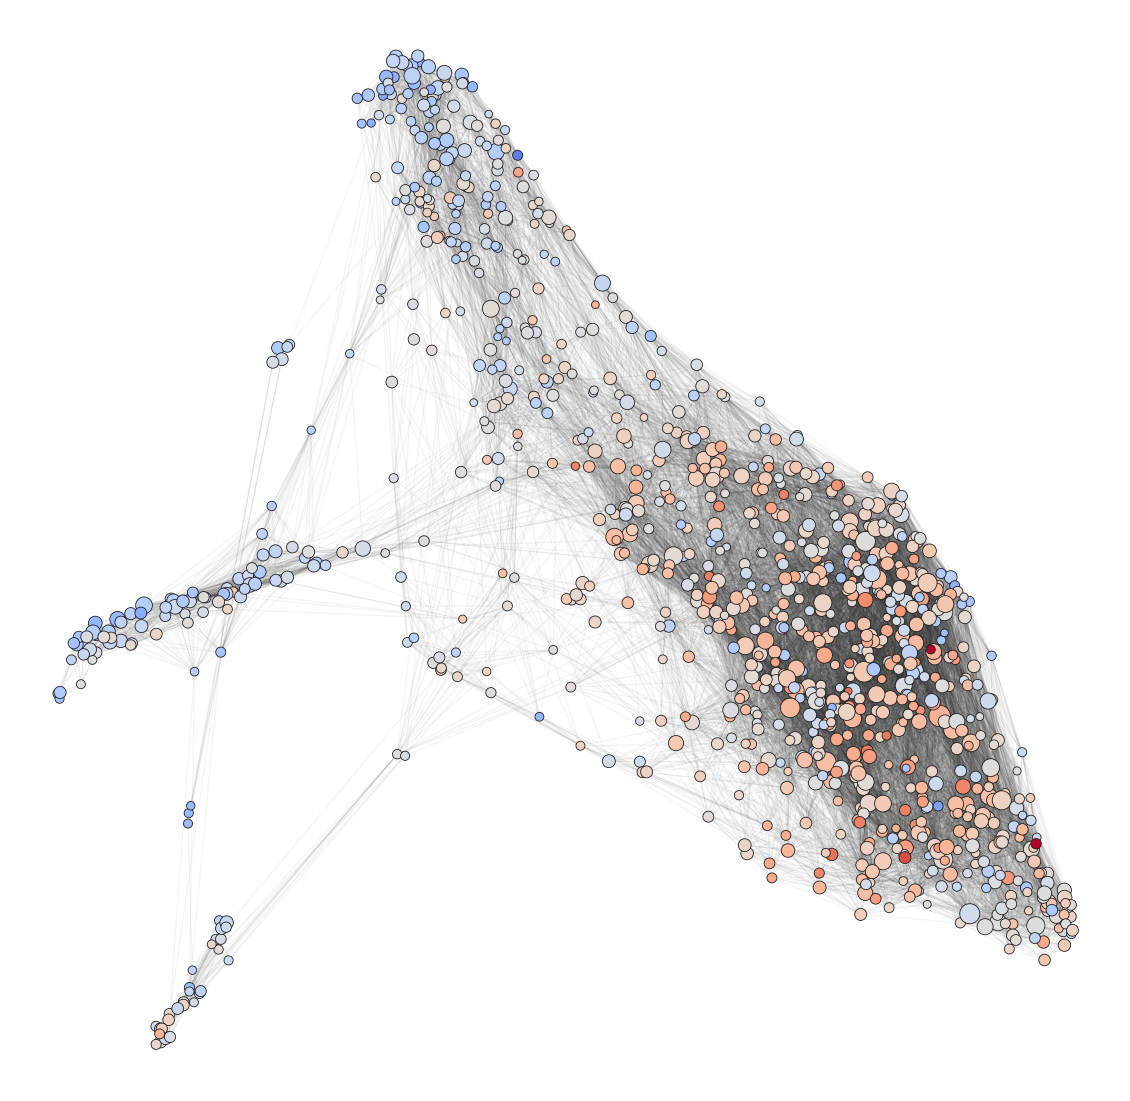

In [28]:
fig,ax=plt.subplots(figsize=(20,20))
plot_G(nh_tsne_df,
           nhood_graph,
           alpha_G=0.05,ax=ax,
           color_G='k',
           s=nh_size*3,
           t=DA_results.logFC,
           cmap='coolwarm',colorbar=False)

<AxesSubplot:>

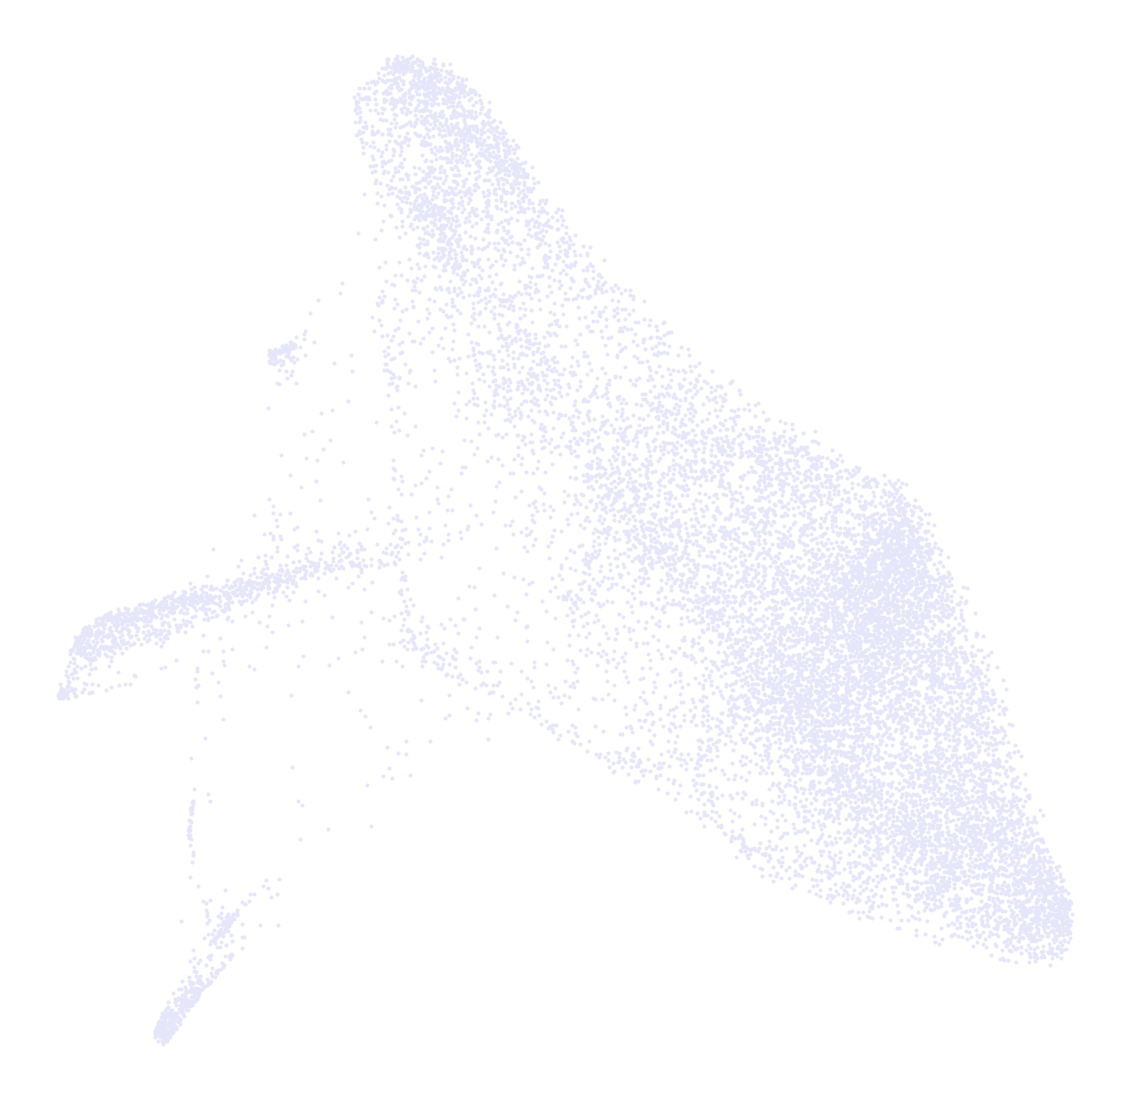

In [29]:
fig,ax=plt.subplots(figsize=(20,20))
ax.scatter(sc.layout_log['x'],sc.layout_log['y'],s=10,c='lavender')

sig_nhoods = np.where(DA_results.SpatialFDR<.1)[0]
plot_G(nh_tsne_df[sig_nhoods,:],
           nhood_graph[sig_nhoods,:][:,sig_nhoods],
           alpha_G=0.1,
           ax=ax,
           color_G='k',
           s=nh_size[sig_nhoods]*5,
           t=DA_results.logFC.values[sig_nhoods],
           cmap='coolwarm',colorbar=False)

In [30]:
DA_results.to_csv(working_dir+"final_outputs/Figure6/DAResultsAnnot_T4.csv",index=True,header=True)